# Deconvolution for human lymph nodes

In [1]:
import stSCI
import scanpy as sc
import pandas as pd
from stSCI.utils.plot import plot_deconvolution, plot_roc_curve

## Data preprocessing

In [2]:
sc_adata = sc.read('data/lymph/scRNA.h5ad')
st_adata = sc.read('data/lymph/ST.h5ad')

sc.pp.highly_variable_genes(sc_adata, flavor='seurat_v3', n_top_genes=3000)
sc.pp.highly_variable_genes(st_adata, flavor='seurat_v3', n_top_genes=3000)
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.log1p(st_adata)

## Model training

For deconvolution, set the `deconvolution` parameter to `True` to generate the deconvolution result. The deconvolution result will save at `st_adata.obsm['decon_result']`. In this section, we illustrate how to use the `stSCI.eval()` function to load saved model parameters and fully reproduce the results. The `stSCI.eval()` function operates similarly to the `stSCI.train()` function, with the key difference being that `stSCI.eval()` requires the `model_path` parameter to specify the path of the model parameter file.

In [3]:
sc_adata, st_adata = stSCI.eval(sc_adata, st_adata, cluster_key='cell_type', deconvolution=True, model_path='model_paras/deconvolution/human_lymph_nodes.pt')

>>> INFO: Filtered 1687 genes.
>>> INFO: Find 1313 same HVGs, result data shapes: [(73260, 1313), (4035, 1313)].
>>> INFO: Generate 28245 edges, 6.000 edges per spot (0.01s).
>>> INFO: Generate 175517 MNN pairs, 2.396 pairs per SC cell; 43.499 pairs per ST spot (4.22s).
>>> INFO: Finish generate deconvolution result (0.35s).
>>> INFO: Inference stSCI model (8.91s).


## Evaluation

We assess the alignment of cell type proportions for the three sub-types of B cell germinal centers (GC) cells within the manually annotated GC region.

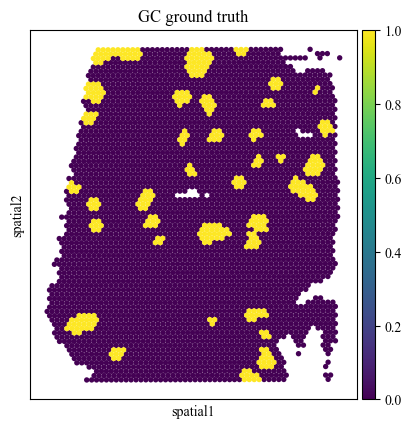

>>> Predicted deconvolution result


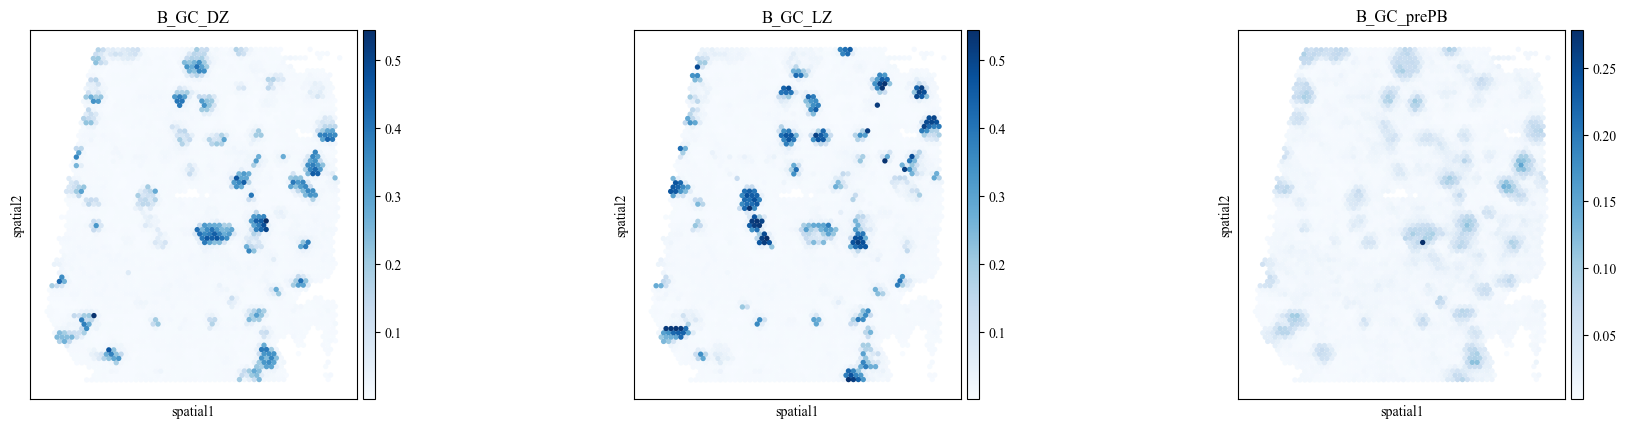

In [4]:
gc_truth = pd.read_csv('data/lymph/manual_GC_annot.csv', index_col=0)
st_adata.obs['gc_label'] = gc_truth['cell_type'].to_numpy()
show_keys = ['B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB']

sc.pl.spatial(st_adata, color='gc_label', title='GC ground truth', img_key=None, spot_size=150)
plot_deconvolution(st_adata, spot_size=150, show_keys=show_keys)

Finally, we calculate the Area Under the Curve (AUC) for the deconvolution results across three regions.

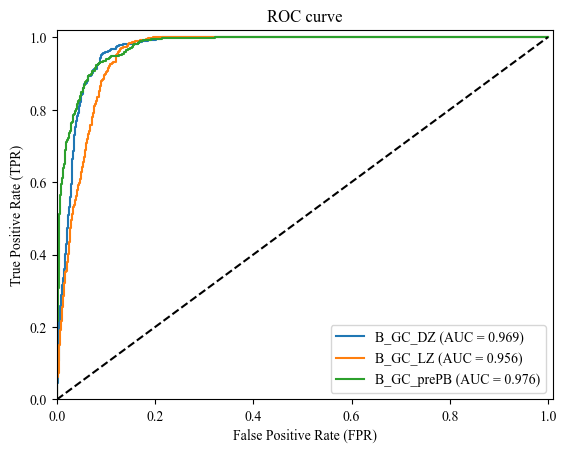

In [5]:
plot_roc_curve(
    [st_adata.obs['gc_label'].to_list()]*3, 
    [item.tolist() for item in st_adata.obsm['decon_result'][show_keys].to_numpy().T],
    show_keys
)